In [1]:
base_dir = '.'

In [2]:
import os
import re
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, roc_curve, auc, confusion_matrix
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.preprocessing import StandardScaler

In [3]:
np.random.seed(42)

In [4]:
erp_df =  pd.read_csv('./archive/ERPdata.csv')

erp_df.head()

,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms
0,1,1,5.533701,5.726507,5.469535,5.386723,4.588875,6.560092,4.542811,5.397492,5.103695,-1500.0000
1,1,1,5.651489,5.837326,5.773131,5.627975,4.822217,6.739976,4.811770,5.541357,5.379273,-1499.0234
2,1,1,5.717580,5.932924,5.948466,5.826460,4.979647,7.026199,5.053779,5.634972,5.600504,-1498.0469
3,1,1,5.703267,5.968103,5.851512,5.812192,4.992899,6.940671,5.106650,5.543577,5.589775,-1497.0703
4,1,1,5.571578,5.917541,5.812808,5.744715,4.963338,6.726491,5.158073,5.454069,5.614092,-1496.0938


# Some things about dataset

In [6]:
demographic_df = pd.read_csv(base_dir + '/archive/demographic.csv')

demographic_df = demographic_df.rename(columns=lambda x: x.strip())
demographic_df['group'] = demographic_df['group'].astype(int)

## Target class distribution

group
1    49
0    32
Name: count, dtype: int64


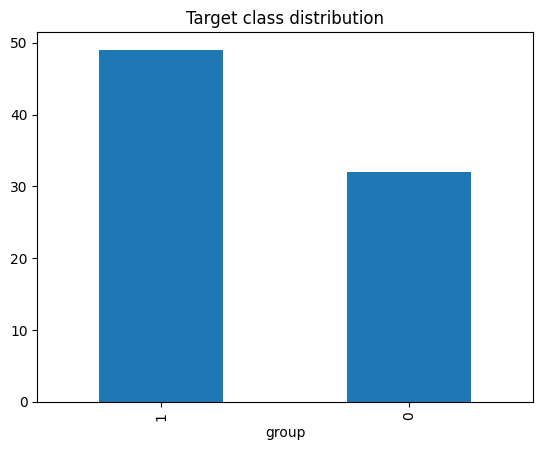

In [7]:
demographic_df['group'].value_counts().plot(kind='bar')
plt.title('Target class distribution')
print(demographic_df['group'].value_counts())

## Classification using RandomForest

The Kaggle dataset includes `ERPdata.csv`. It's already processed file, however, as authors said it can be used to `replicate prior thesis` so it's useful but doesn't contain all the data to replicate the article we are working on.

What we are doing in this section is:
- visualization of n100, p200 windows
- extracting features for RandomForest (it cannot work with timeseries):
  - n100 min amplitude, p200 max amplitude
  - mean ampltitude during n100 time window
  - mean amplitude during p200 time window
  - above is done for each electrode separately, now we have 18 features after doing all the work written above
- fitting RandomForestClassifer using RFECV (feature selection) and StratifiedKFold  

What we are missing: more features (we would need to include more electrodes and calculate also slopes of EEG func), we are going to do it later in the notebook


In [8]:
df = erp_df.merge(demographic_df, left_on='subject', right_on='subject')

df = df.rename(columns=lambda x: x.strip())

In [9]:
df.info()

electrodes = ['Fz','FCz','Cz','FC3','FC4','C3','C4','CP3','CP4']
features_electrodes = ['Fz', 'FCz', 'Cz', 'CP4']
n100_window = (75, 120)
p200_window = (150, 250)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 746496 entries, 0 to 746495
Data columns (total 16 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   subject    746496 non-null  int64  
 1   condition  746496 non-null  int64  
 2   Fz         746496 non-null  float64
 3   FCz        746496 non-null  float64
 4   Cz         746496 non-null  float64
 5   FC3        746496 non-null  float64
 6   FC4        746496 non-null  float64
 7   C3         746496 non-null  float64
 8   C4         746496 non-null  float64
 9   CP3        746496 non-null  float64
 10  CP4        746496 non-null  float64
 11  time_ms    746496 non-null  float64
 12  group      746496 non-null  int64  
 13  gender     746496 non-null  object 
 14  age        746496 non-null  int64  
 15  education  746496 non-null  float64
dtypes: float64(11), int64(4), object(1)
memory usage: 91.1+ MB


,subject,condition,Fz,FCz,Cz,FC3,FC4,C3,C4,CP3,CP4,time_ms,group,gender,age,education
0,1,1,5.533701,5.726507,5.469535,5.386723,4.588875,6.560092,4.542811,5.397492,5.103695,-1500.0000,0,M,44,16.0
1,1,1,5.651489,5.837326,5.773131,5.627975,4.822217,6.739976,4.811770,5.541357,5.379273,-1499.0234,0,M,44,16.0
2,1,1,5.717580,5.932924,5.948466,5.826460,4.979647,7.026199,5.053779,5.634972,5.600504,-1498.0469,0,M,44,16.0
3,1,1,5.703267,5.968103,5.851512,5.812192,4.992899,6.940671,5.106650,5.543577,5.589775,-1497.0703,0,M,44,16.0
4,1,1,5.571578,5.917541,5.812808,5.744715,4.963338,6.726491,5.158073,5.454069,5.614092,-1496.0938,0,M,44,16.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746491,81,3,-0.401267,0.041014,-0.352556,0.712530,-0.427019,0.479170,1.041864,0.645761,-0.085649,1495.1172,1,M,56,13.0
746492,81,3,-0.440294,0.093863,-0.422151,0.792209,-0.469230,0.486767,0.955658,0.601938,-0.264824,1496.0938,1,M,56,13.0
746493,81,3,-0.466162,0.083799,-0.485091,0.799034,-0.466002,0.516740,0.972635,0.612470,-0.463196,1497.0703,1,M,56,13.0
746494,81,3,-0.472620,0.003017,-0.465663,0.675452,-0.408777,0.558901,0.943028,0.635287,-0.656748,1498.0469,1,M,56,13.0


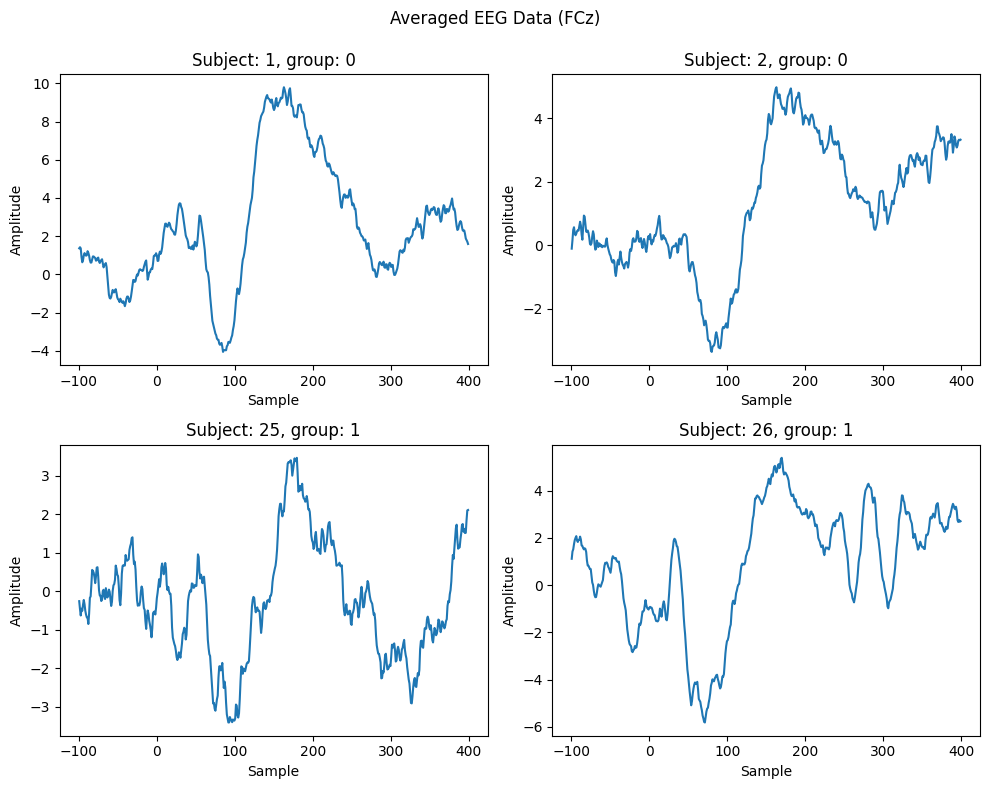

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'Averaged EEG Data (FCz)')

subjects = list(df[df['group'] == 0 ]['subject'].unique()[:2]) + list(df[df['group'] == 1 ]['subject'].unique()[:2])
for ax in axs.flat:
  subject = subjects[0]
  subjects = subjects[1:]

  subject_data = df[df['subject'] == subject]
  subject_data = subject_data[subject_data['condition'] == 1]
  subject_data = subject_data[(subject_data['time_ms'] >= -100) & (subject_data['time_ms'] < 400)]

  ax.plot(subject_data['time_ms'], subject_data['FCz'])

  ax.set_title(f'Subject: {subject}, group: {subject_data["group"].values[0]}')
  ax.set_xlabel('Sample')
  ax.set_ylabel('Amplitude')

plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()


In [16]:
df = df.groupby(['subject', 'time_ms', 'group'], as_index=False)[electrodes].mean()

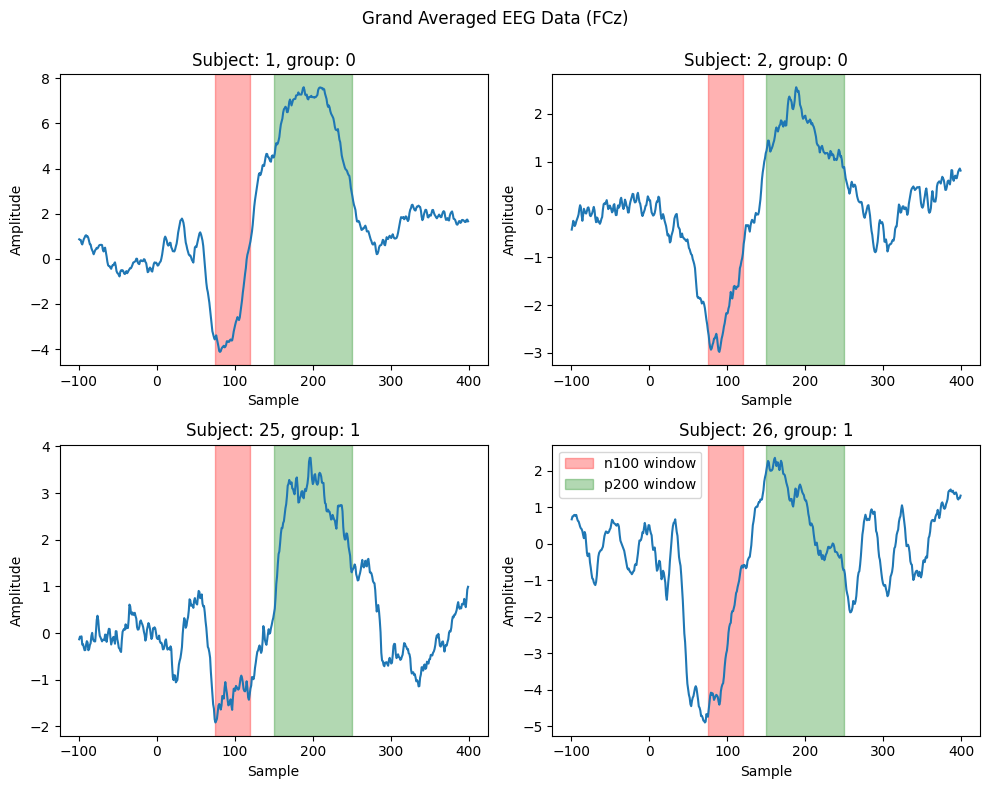

In [20]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
fig.suptitle(f'Grand Averaged EEG Data (FCz)')

subjects = list(df[df['group'] == 0 ]['subject'].unique()[:2]) + list(df[df['group'] == 1 ]['subject'].unique()[:2])
for ax in axs.flat:
  subject = subjects.pop(0)

  subject_data = df[df['subject'] == subject]
  subject_data = subject_data[(subject_data['time_ms'] >= -100) & (subject_data['time_ms'] < 400)]

  ax.plot(subject_data['time_ms'], subject_data['FCz'])

  ax.set_title(f'Subject: {subject}, group: {subject_data["group"].values[0]}')
  ax.set_xlabel('Sample')
  ax.set_ylabel('Amplitude')

  ax.axvspan(n100_window[0], n100_window[1], color='red', alpha=0.3, label='n100 window')

  ax.axvspan(p200_window[0], p200_window[1], color='green', alpha=0.3, label='p200 window')



plt.legend()
plt.tight_layout()
plt.subplots_adjust(top=0.9)

plt.show()


In [21]:
n100_electrodes = p200_electrodes = features_electrodes

def extract_n100_p200_at_channels(df):
  n100_time_window = df[(df['time_ms'] >= n100_window[0]) & (df['time_ms'] <= n100_window[1])]
  n100_data = n100_time_window[n100_electrodes]

  p200_time_window = df[(df['time_ms'] >= p200_window[0]) & (df['time_ms'] <= p200_window[1])]
  p200_data = p200_time_window[p200_electrodes]

  # we pick min/max separately for each electrode
  n100_min_amplitude = n100_data.min()
  p200_max_amplitude = p200_data.max()

  n100_mean = n100_data.mean()
  p200_mean = p200_data.mean()

  # order is important
  return [*n100_min_amplitude, *p200_max_amplitude, *n100_mean, *p200_mean]

In [22]:
new_columns = []
new_columns_names = ['subject', 'group']

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_min')

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_max')

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_n100_mean')

for feature in features_electrodes:
  new_columns_names.append(f'{feature}_p200_mean')

subjects = df['subject'].unique()

In [23]:
for subject in subjects:
  chunk = df[df['subject'] == subject]
  group = chunk['group'].unique()[0]
  new_columns.append([subject, group] + extract_n100_p200_at_channels(chunk))


finished = pd.DataFrame(new_columns, columns=new_columns_names)

In [24]:
finished

,subject,group,Fz_min,FCz_min,Cz_min,CP4_min,Fz_max,FCz_max,Cz_max,CP4_max,Fz_n100_mean,FCz_n100_mean,Cz_n100_mean,CP4_n100_mean,Fz_p200_mean,FCz_p200_mean,Cz_p200_mean,CP4_p200_mean
0,1,0,-4.090748,-4.121576,-3.737266,-3.773544,6.157657,7.599826,8.580174,7.270768,-2.891426,-2.713102,-2.318303,-2.766619,4.997193,6.292587,7.185316,5.998910
1,2,0,-2.837412,-2.979100,-2.561709,-1.292227,2.307966,2.555137,2.529818,1.483320,-2.097573,-2.219484,-1.933317,-1.062198,1.428895,1.604380,1.712032,0.934198
2,3,0,-4.548531,-5.160870,-4.761727,-2.261804,3.595253,4.549231,4.351878,2.656433,-2.940422,-3.392156,-3.307845,-1.620689,2.979162,3.539601,3.287098,1.746805
3,4,0,-5.702859,-5.040546,-3.710445,-1.867876,5.966823,6.164893,5.473190,3.676127,-3.756440,-3.187781,-2.198955,-1.062000,3.801529,4.317054,3.919627,2.870453
4,5,0,-4.938117,-4.815960,-4.116232,-2.744590,3.920788,4.024129,3.749325,2.531878,-3.344271,-3.470074,-2.939628,-1.926975,1.890236,2.466983,2.645140,1.798795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,77,1,-1.425233,-1.266759,-0.336953,-0.825334,4.660782,6.092024,1.178260,2.791210,-0.861194,-0.265750,-0.058033,0.005937,2.745699,3.762794,0.683322,1.270664
77,78,1,-4.096642,-3.576038,-3.735105,-3.079162,5.286395,6.470762,6.482188,4.825780,-1.760398,-0.809632,-0.793970,-0.979525,1.909463,3.172349,3.345463,2.618979
78,79,1,-4.875870,-5.161239,-4.128335,-4.311345,3.099469,4.035979,4.415603,2.720204,-2.879404,-3.260340,-2.846680,-3.609180,1.131077,2.340366,2.533711,0.884110
79,80,1,-2.567036,-2.339278,-1.809674,-1.792925,1.296482,2.076804,2.045176,0.830934,-1.670736,-1.288131,-0.776616,-1.086703,-0.089371,0.393849,0.446656,-0.337522


In [25]:
finished.columns

Index(['subject', 'group', 'Fz_min', 'FCz_min', 'Cz_min', 'CP4_min', 'Fz_max',
       'FCz_max', 'Cz_max', 'CP4_max', 'Fz_n100_mean', 'FCz_n100_mean',
       'Cz_n100_mean', 'CP4_n100_mean', 'Fz_p200_mean', 'FCz_p200_mean',
       'Cz_p200_mean', 'CP4_p200_mean'],
      dtype='object')

In [96]:
def run_training_and_predict(X, y, seed, min_features_to_select):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)
    rf = RandomForestClassifier(n_estimators = 100, max_depth=2, max_features=15, random_state=seed)

    skf = StratifiedKFold(n_splits=5)

    rfecv = RFECV(estimator=rf, step=1, min_features_to_select=min_features_to_select, cv=skf)
    rfecv.fit(X_train, y_train)

    rf.fit(X_train[:, rfecv.support_], y_train)

    y_pred = rf.predict(X_test[:, rfecv.support_])
    return y_test, y_pred

In [52]:
X = finished[new_columns_names[2:]]
y = finished['group'].astype(int)

In [102]:
def specificity_score(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return tn / (tn+fp)

def evaluate(X, y, num_retries, min_features_to_select=10):
    # we have a tiny dataset and running on just one seed isnt reliable
    accs, precs, recalls, f1s, specs = [], [], [], [], []
    metrics = [accs, precs, recalls, f1s, specs]
    metric_names = ['accuracy', 'precision', 'recall', 'f1', 'specificity']
    start_seed = 40
    split_seeds = range(start_seed, start_seed + num_retries)
    test_pred_pairs = []
    for seed in tqdm(split_seeds):
        test_pred_pairs.append(run_training_and_predict(X, y, seed, min_features_to_select)) 

    for y_test, y_pred in test_pred_pairs:
        for target, metric in zip(metrics, [accuracy_score, precision_score, recall_score, f1_score, specificity_score]):
            target.append(metric(y_test, y_pred))

    combined_y_test = np.hstack([x[0] for x in test_pred_pairs])
    combined_y_pred = np.hstack([x[1] for x in test_pred_pairs])
    print(classification_report(combined_y_test, combined_y_pred))

    metric_results = []
    for metric, name in zip(metrics, metric_names):
        print(name)
        print(f'mean={np.mean(metric)}\tstd={np.std(metric)}')
        metric_results.append((name, np.mean(metric)))

    return test_pred_pairs

In [53]:
test_pred_pairs = evaluate(X.to_numpy(), y.to_numpy(), 10, 14)

100%|██████████| 10/10 [00:09<00:00,  1.04it/s]

              precision    recall  f1-score   support

           0       0.52      0.52      0.52        60
           1       0.74      0.74      0.74       110

    accuracy                           0.66       170
   macro avg       0.63      0.63      0.63       170
weighted avg       0.66      0.66      0.66       170

accuracy
mean=0.6588235294117647	std=0.12561268531801542
precision
mean=0.7491841491841491	std=0.20410637630467118
recall
mean=0.741067266067266	std=0.10693244133570134
f1
mean=0.7285921820361181	std=0.12342463427212508
specificity
mean=0.5955555555555556	std=0.24318869369430138


In [30]:
seed_42_results = test_pred_pairs[2]
print(classification_report(*seed_42_results))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.82      0.82      0.82        11

    accuracy                           0.76        17
   macro avg       0.74      0.74      0.74        17
weighted avg       0.76      0.76      0.76        17




In the previous section, we accomplished the following:
- **Visualization of N100 and P200 windows.**
- **Calculation of 'grand averages':** Averaging time series from three conditions for each subject, reducing it to a single time series per subject.
- **Feature Extraction for RandomForest:**
  - Minimum amplitude during the N100 window and maximum amplitude during the P200 window.
  - Mean amplitude during the N100 and P200 time windows.
  - Performed separately for each electrode, resulting in 18 distinct features.
- **Fitted a RandomForestClassifier:** Employing RFECV for feature selection and StratifiedKFold for cross-validation.

## Current Status

- We have a foundational model, which now allows for experimentation with hyperparameters and the addition of extra features.


---
## Using all features used in the paper

In their experiments authors recommended using `['Fz', 'FCz', 'Cz', 'CPz', 'Pz']` electrodes, raw data doesn't contain all of them, the function below computes values for missing electrodes the same way they were computed in ERPdata.csv file that we downloaded.

In [31]:
SUBJECT_DATA_FILE_REGEX = re.compile(r'(\d{1,2}).csv')
METADATA_DIR_PATH = base_dir + '/archive'
DATA_DIR_RAW_PATHS = (METADATA_DIR_PATH, base_dir + '/archive2')
STRIPPED_DATA_PATH = base_dir + '/stripped'

def preprare_erp_data(archive_paths=DATA_DIR_RAW_PATHS, target_path=STRIPPED_DATA_PATH, metadata_dir=METADATA_DIR_PATH,
        column_labels_filename='columnLabels.csv', erp_data_filename='ERPdata.csv',
        electrodes=['Fz', 'FCz', 'Cz', 'CPz', 'Pz'], condition=2):
    erp_data = pd.read_csv(os.path.join(metadata_dir, erp_data_filename))
    column_labels_df = pd.read_csv(os.path.join(metadata_dir, column_labels_filename))

    erp_data = erp_data[erp_data['condition'] == condition]

    try:
        os.mkdir(target_path)
    except FileExistsError:
        pass

    missing_electrodes = [electrode for electrode in electrodes if electrode not in erp_data.columns]
    for electrode in missing_electrodes:
        erp_data[electrode] = erp_data.apply(lambda _: 0.)
    
    added_subjects = set()

    if missing_electrodes:
        for dir in archive_paths:
            for file_name in tqdm(os.listdir(dir)):
                if match := SUBJECT_DATA_FILE_REGEX.match(file_name):
                    subject_id = int(match.group(1))
                    added_subjects.add(subject_id)
                    path = os.path.join(dir, file_name, file_name)
                    data = pd.read_csv(path)
                    data.columns = column_labels_df.columns
                    means = data[(data['condition'] == condition)][['sample', *missing_electrodes]].groupby(['sample']).mean()
                    for electrode in missing_electrodes:
                        erp_data.loc[erp_data['subject'] == subject_id, electrode] = means[electrode].to_numpy()
            
        assert len(set(erp_data['subject'].unique()) - added_subjects) == 0

    erp_data.to_csv(os.path.join(target_path, erp_data_filename), index=False)

    return erp_data

Check if it looks the same for previously computed electrodes:

In [32]:
testing_subject = pd.read_csv(base_dir + '/archive/1.csv/1.csv')
labels = pd.read_csv(base_dir + '/archive/columnLabels.csv')
testing_subject.columns = labels.columns
testing_subject_id = testing_subject['subject'].iloc[0]

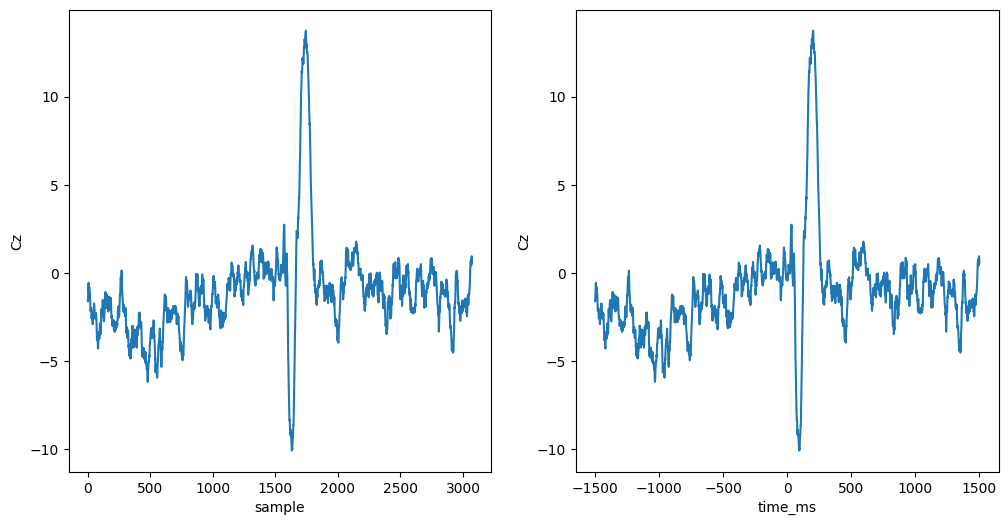

In [33]:
fig, ax = plt.subplots(1, 2,  figsize=(12, 6))
electrode = 'Cz'
per_sample_averaged_cz_electrode = testing_subject[(testing_subject['condition'] == 2)][['sample', electrode]].groupby(['sample']).mean()
precomputed_erp_data = erp_df[(erp_df['subject'] == testing_subject_id) & (erp_df['condition'] == 2)]
 
sns.lineplot(per_sample_averaged_cz_electrode, x='sample', y=electrode, ax=ax[0])
sns.lineplot(precomputed_erp_data, x='time_ms', y=electrode, ax=ax[1])
plt.show()

In [29]:
# preprare_erp_data()

The function below computes features descibed in the paper (section: 3.3.1. Feature Extraction):
- slopes for: the beginning of N100 deflection, the transition from N100 to P200, and the final descending section of the P200 component
- mean values for n_100 and p_200 time ranges for selected electrodes
- amplitude and latency of peak signal values in n_100 and p_200 (min and max respectively) ranges for other selected electrodes

It leaves only the selected condition.

In [34]:
def create_rf_features(data_dir=STRIPPED_DATA_PATH, metadata_dir=METADATA_DIR_PATH, erp_data_filename='ERPdata.csv',
        electrodes=['Fz', 'FCz', 'Cz', 'CPz', 'Pz'], amplitude_latency_electrodes=['FCz', 'Cz'],
        min_N100_time=75., max_N100_time=105., min_P200_time=150., max_P200_time=210.,
        slope_segments=((50., 75.), (105., 150.), (250., 280.))):
    erp_data = pd.read_csv(os.path.join(data_dir, erp_data_filename))
    demographic = pd.read_csv(os.path.join(metadata_dir, 'demographic.csv')).set_index('subject')
    X = []
    Y = []
    subject_idxs = erp_data['subject'].unique()

    feature_names = []
    for i in range(len(slope_segments)):
        feature_names.extend([f'slope{i + 1}_{electrode}' for electrode in electrodes])
    feature_names.extend([f'n100_mean_{electrode}' for electrode in electrodes])
    for electrode in amplitude_latency_electrodes:
        feature_names.extend([f'n100_amp_{electrode}', f'n100_lat_{electrode}'])
    feature_names.extend([f'p200_mean_{electrode}' for electrode in electrodes])
    for electrode in amplitude_latency_electrodes:
        feature_names.extend([f'p200_amp_{electrode}', f'p200_lat_{electrode}'])

    for subject_id in subject_idxs:
        Y.append(demographic.loc[subject_id][' group'])
        subject_data = erp_data[erp_data['subject'] == subject_id]
        times = subject_data['time_ms'].to_numpy()
        features = []

        for slope_start, slope_end in slope_segments:
            start_idx = np.argmin(np.abs(times - slope_start))
            end_idx = np.argmin(np.abs(times - slope_end))

            per_electrode_signal_diffs = subject_data.iloc[end_idx][electrodes] - subject_data.iloc[start_idx][electrodes]
            per_electrode_time_diffs = times[end_idx] - times[start_idx]
            per_electrode_slopes = per_electrode_signal_diffs / per_electrode_time_diffs 
            features.extend(list(per_electrode_slopes))

        n100_time_range = subject_data[(subject_data['time_ms'] >= min_N100_time) & (subject_data['time_ms'] <= max_N100_time)]
        features.extend(list(n100_time_range.mean()[electrodes]))

        for electrode in amplitude_latency_electrodes:
            n100_peak_info = n100_time_range.loc[n100_time_range[electrode].idxmin()]
            amplitude, latency = n100_peak_info[electrode], n100_peak_info['time_ms']
            features.append(amplitude)
            features.append(latency)

        p200_time_range = subject_data[(subject_data['time_ms'] >= min_P200_time) & (subject_data['time_ms'] <= max_P200_time)]
        features.extend(list(p200_time_range.mean()[electrodes]))

        for electrode in amplitude_latency_electrodes:
            p200_peak_info = p200_time_range.loc[p200_time_range[electrode].idxmax()]
            amplitude, latency = p200_peak_info[electrode], p200_peak_info['time_ms']
            features.append(amplitude)
            features.append(latency)

        X.append(np.array(features))
    
    return np.stack(X, axis=0), np.array(Y), subject_idxs, feature_names

In [35]:
X, Y, idx, feature_names = create_rf_features()
df = pd.DataFrame(np.hstack([X, Y[:,np.newaxis]]), columns=feature_names + ['group'])
df.head()

,slope1_Fz,slope1_FCz,slope1_Cz,slope1_CPz,slope1_Pz,slope2_Fz,slope2_FCz,slope2_Cz,slope2_CPz,slope2_Pz,...,p200_mean_Fz,p200_mean_FCz,p200_mean_Cz,p200_mean_CPz,p200_mean_Pz,p200_amp_FCz,p200_lat_FCz,p200_amp_Cz,p200_lat_Cz,group
0,-0.270509,-0.324466,-0.362394,-0.321853,-0.269839,0.213145,0.251289,0.288256,0.299540,0.265273,...,7.765408,9.793892,11.082069,10.301699,9.357244,12.437850,202.1484,13.738176,202.1484,0.0
1,-0.132411,-0.145158,-0.134585,-0.101566,-0.055878,0.098965,0.106535,0.101157,0.078137,0.057617,...,1.269186,1.452666,1.683378,1.130333,0.904933,2.748895,188.4766,2.926059,195.3125,0.0
2,-0.221593,-0.236675,-0.205573,-0.149323,-0.091235,0.184453,0.216576,0.211656,0.165557,0.121691,...,3.063873,4.058768,3.950415,2.866893,2.076988,4.917532,178.7109,4.737715,151.3672,0.0
3,-0.226696,-0.193974,-0.152838,-0.081004,-0.035975,0.291549,0.282089,0.232271,0.149306,0.091293,...,7.269227,7.723196,6.727506,4.600551,3.118764,9.468185,182.6172,8.144822,182.6172,0.0
4,-0.234087,-0.225591,-0.194728,-0.152396,-0.126795,0.146913,0.155830,0.142160,0.120001,0.089003,...,2.118483,2.654049,2.669709,2.558687,1.612938,4.637015,208.9844,4.296438,208.9844,0.0


Check for one subject electrode if features are computed correctly

In [36]:
testing_subject_idx = np.argwhere(np.array(idx) == testing_subject_id)
subject_features = df.iloc[testing_subject_idx[0, 0]]
subject_features = subject_features.loc[[x for x in subject_features.index if f'_{electrode}' in x]]
subject_features

slope1_Cz        -0.362394
slope2_Cz         0.288256
slope3_Cz        -0.137503
n100_mean_Cz     -9.248444
n100_amp_Cz     -10.069123
n100_lat_Cz      93.750000
p200_mean_Cz     11.082069
p200_amp_Cz      13.738176
p200_lat_Cz     202.148400
Name: 0, dtype: float64

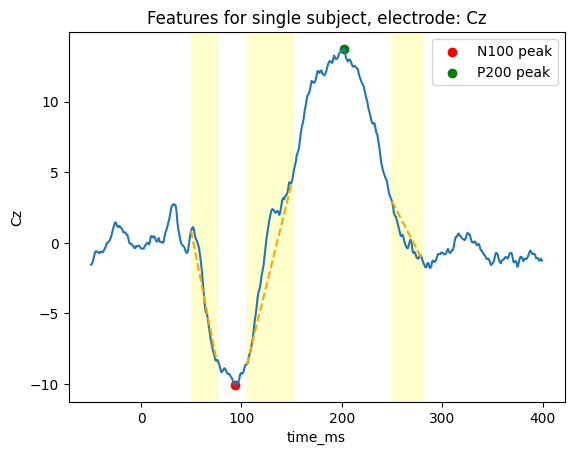

In [37]:
slope_segments=((50., 75.), (105., 150.), (250., 280.))
fig, ax = plt.subplots()
partial_cz_data = precomputed_erp_data
sns.lineplot(precomputed_erp_data[(precomputed_erp_data['time_ms']>-50) & (precomputed_erp_data['time_ms']<400)],
             x='time_ms', y=electrode, ax=ax)
n_100_peak = (subject_features[f'n100_lat_{electrode}'], subject_features[f'n100_amp_{electrode}'])
p_200_peak = (subject_features[f'p200_lat_{electrode}'], subject_features[f'p200_amp_{electrode}'])
ax.scatter(*n_100_peak, color='red', marker='o', label='N100 peak')
ax.scatter(*p_200_peak, color='green', marker='o', label='P200 peak')


for i, (slope_start, slope_end) in enumerate(slope_segments):
    slope_stard_idx = np.argmin(np.abs(precomputed_erp_data['time_ms'] - slope_start))
    slope_end_idx = np.argmin(np.abs(precomputed_erp_data['time_ms'] - slope_end))
    time_start, amp_start = precomputed_erp_data.iloc[slope_stard_idx][['time_ms', electrode]]
    time_end, amp_end = precomputed_erp_data.iloc[slope_end_idx][['time_ms', electrode]]

    ax.plot([time_start, time_end], [amp_start, amp_end], color='orange', linestyle='--', linewidth=1.5)
    assert np.isclose(subject_features[f'slope{i+1}_{electrode}'], (amp_end - amp_start) / (time_end - time_start))
    ax.axvspan(time_start, time_end, color='yellow', alpha=0.2)

ax.set_title(f'Features for single subject, electrode: {electrode}')
ax.legend()
plt.show()

Train using all 33 features:

In [89]:
X, Y, idx, feature_names = create_rf_features()

In [104]:
test_pred_pairs = evaluate(X, Y, 10, min_features_to_select=24)

100%|██████████| 10/10 [00:31<00:00,  3.15s/it]

              precision    recall  f1-score   support

           0       0.51      0.65      0.57        60
           1       0.77      0.65      0.71       110

    accuracy                           0.65       170
   macro avg       0.64      0.65      0.64       170
weighted avg       0.68      0.65      0.66       170

accuracy
mean=0.6529411764705884	std=0.1
precision
mean=0.7971969696969697	std=0.19519474975679832
recall
mean=0.6673951048951048	std=0.11449841548514479
f1
mean=0.7044650376619686	std=0.09592242891835313
specificity
mean=0.7313888888888889	std=0.23455385151231106


In [100]:
seed_42_results = test_pred_pairs[2]
print(classification_report(*seed_42_results))

              precision    recall  f1-score   support

           0       0.67      0.67      0.67         6
           1       0.82      0.82      0.82        11

    accuracy                           0.76        17
   macro avg       0.74      0.74      0.74        17
weighted avg       0.76      0.76      0.76        17



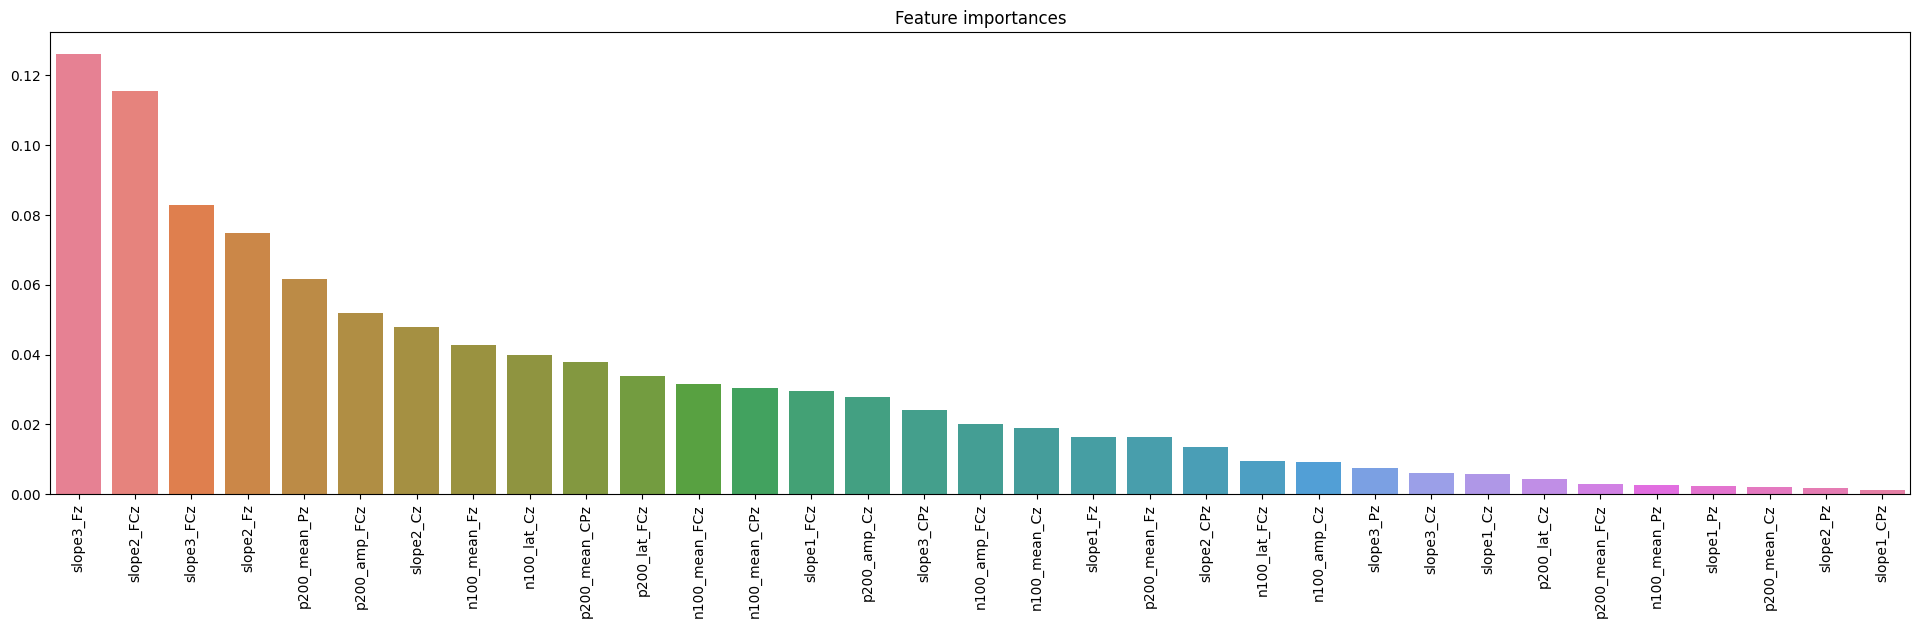

In [101]:
clf = RandomForestClassifier(n_estimators=100, max_depth=2, max_features=15).fit(X, Y)
plt.figure(figsize=(24, 6))
sorted_feature_importances, sorted_feature_names = zip(*sorted(zip(clf.feature_importances_, feature_names), key=lambda x: x[0], reverse=True))
df = pd.DataFrame(np.array(sorted_feature_importances).reshape(1, -1), columns=sorted_feature_names)
sns.barplot(df)
plt.xticks(rotation=90)
plt.title("Feature importances")
plt.show()